In [58]:
import os
import re
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


In [59]:
device=("cuda" if torch.cuda.is_available() else "cpu")
device

'cpu'

In [61]:
# print(data['failureType'].value_counts())

In [62]:
# data["failureType"].unique()

In [75]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

IMG_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 5
NUM_WORKERS = 0  # Windows safe

CLASSES = [
    "clean", "Center", "Donut", "Edge-Loc",
    "Edge-Ring", "Loc", "Random",
    "Scratch", "Near-Full"
]

NUM_CLASSES = len(CLASSES)
BASE_DIR = "LSWMD_DATA"


In [64]:
data = pd.read_pickle("LSWMD.pkl (1)/LSWMD.pkl")
df = data[data["failureType"].notnull()].reset_index(drop=True)

def extract_label(x):
    if isinstance(x, np.ndarray):
        x = x[0] if len(x) > 0 else "other"
    return str(x).strip()

def clean_label(x):
    return re.sub(r"[\[\]']", "", x)

def map_label(x):
    x = x.strip()
    if x.lower() == "none":
        return "clean"
    if x.lower() == "near-full":
        return "Near-Full"
    return x if x in CLASSES else "other"

df["failure_str"] = df["failureType"].apply(extract_label)
df["failure_clean"] = df["failure_str"].apply(clean_label)
df["label"] = df["failure_clean"].apply(map_label)

# Remove massive "other" class
df = df[df["label"] != "other"].reset_index(drop=True)

print(df["label"].value_counts())


clean        147431
Edge-Ring      9680
Edge-Loc       5189
Center         4294
Loc            3593
Scratch        1193
Random          866
Donut           555
Near-Full       149
Name: label, dtype: int64


In [65]:
train_df, temp_df = train_test_split(
    df, test_size=0.3, stratify=df["label"], random_state=42
)

val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42
)

splits = {
    "Train": train_df,
    "Validation": val_df,
    "Test": test_df
}


In [66]:
def wafer_to_image(wafer):
    wafer = np.nan_to_num(wafer)
    img = np.zeros_like(wafer, dtype=np.uint8)
    img[wafer == -1] = 0
    img[wafer == 0] = 127
    img[wafer == 1] = 255

    h, w = img.shape
    size = max(h, w)
    canvas = np.zeros((size, size), dtype=np.uint8)
    canvas[:h, :w] = img

    return cv2.resize(canvas, (IMG_SIZE, IMG_SIZE))

for split in splits:
    for cls in CLASSES:
        os.makedirs(os.path.join(BASE_DIR, split, cls), exist_ok=True)

for split, split_df in splits.items():
    print(f"Saving {split} images...")
    for idx, row in tqdm(split_df.iterrows(), total=len(split_df)):
        img = wafer_to_image(row["waferMap"])
        path = os.path.join(BASE_DIR, split, row["label"], f"{idx}.png")
        cv2.imwrite(path, img)


Saving Train images...


100%|██████████| 121065/121065 [02:40<00:00, 753.61it/s]


Saving Validation images...


100%|██████████| 25942/25942 [00:32<00:00, 789.23it/s]


Saving Test images...


100%|██████████| 25943/25943 [00:32<00:00, 787.90it/s]


In [67]:
class WaferDataset(Dataset):
    def __init__(self, root_dir, classes, transform=None):
        self.samples = []
        self.transform = transform
        self.class_to_idx = {c:i for i,c in enumerate(classes)}

        for cls in classes:
            folder = os.path.join(root_dir, cls)
            for img in os.listdir(folder):
                self.samples.append(
                    (os.path.join(folder, img), self.class_to_idx[cls])
                )

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = np.stack([img]*3, axis=-1)

        if self.transform:
            img = self.transform(image=img)["image"]

        return img, label


In [68]:
train_tfms = A.Compose([
    A.Rotate(limit=15),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(0.05, 0.1, p=0.5),
    A.GaussNoise(p=0.2),
    A.Normalize(mean=(0.5,)*3, std=(0.5,)*3),
    ToTensorV2()
])

val_tfms = A.Compose([
    A.Normalize(mean=(0.5,)*3, std=(0.5,)*3),
    ToTensorV2()
])


c:\Users\Acer\OneDrive\Documents\krish python\ML\i4c_hackathon\.venv\Lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [69]:
train_ds = WaferDataset(f"{BASE_DIR}/Train", CLASSES, train_tfms)
val_ds = WaferDataset(f"{BASE_DIR}/Validation", CLASSES, val_tfms)
test_ds = WaferDataset(f"{BASE_DIR}/Test", CLASSES, val_tfms)

train_loader = DataLoader(train_ds, BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_ds, BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_ds, BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)


In [70]:
model = timm.create_model("convnext_tiny", pretrained=True, num_classes=NUM_CLASSES).to(DEVICE)

for param in model.parameters():
    param.requires_grad = False

for param in model.head.parameters():
    param.requires_grad = True



In [71]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=3e-4,
    steps_per_epoch=len(train_loader),
    epochs=EPOCHS
)

scaler = GradScaler()


C:\Users\Acer\AppData\Local\Temp\ipykernel_3720\1914797252.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
c:\Users\Acer\OneDrive\Documents\krish python\ML\i4c_hackathon\.venv\Lib\site-packages\torch\cuda\amp\grad_scaler.py:31: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  super().__init__(


In [72]:
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.parameters())

print(f"Trainable params: {trainable}/{total}")


Trainable params: 8457/27827049


In [73]:
from torch.utils.data import WeightedRandomSampler

labels = np.array([y for _, y in train_ds])
class_counts = np.bincount(labels)
class_weights = 1.0 / class_counts
sample_weights = class_weights[labels]

sampler = WeightedRandomSampler(
    sample_weights,
    len(sample_weights),
    replacement=True
)

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    num_workers=NUM_WORKERS
)


In [77]:
best_f1 = 0

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0

    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()

        with autocast():
            preds = model(x)
            loss = criterion(preds, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        train_loss += loss.item()
        if epoch == 5:
            for param in model.parameters():
                param.requires_grad = True


    model.eval()
    preds_all, labels_all = [], []

    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(DEVICE)
            preds = model(x).argmax(1).cpu()
            preds_all.extend(preds.numpy())
            labels_all.extend(y.numpy())

    macro_f1 = f1_score(labels_all, preds_all, average="macro")

    print(f"Epoch {epoch+1} | Loss {train_loss:.3f} | F1 {macro_f1:.4f}")

    if macro_f1 > best_f1:
        best_f1 = macro_f1
        torch.save(model.state_dict(), "best_model.pth")



Epoch 1:   0%|          | 0/3784 [00:00<?, ?it/s]C:\Users\Acer\AppData\Local\Temp\ipykernel_3720\1998886407.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1: 100%|██████████| 3784/3784 [1:54:13<00:00,  1.81s/it]  


Epoch 1 | Loss 1909.076 | F1 0.6364


Epoch 2:   0%|          | 0/3784 [00:00<?, ?it/s]C:\Users\Acer\AppData\Local\Temp\ipykernel_3720\1998886407.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
c:\Users\Acer\OneDrive\Documents\krish python\ML\i4c_hackathon\.venv\Lib\site-packages\torch\cuda\amp\autocast_mode.py:54: UserWarning: CUDA is not available or torch_xla is imported. Disabling autocast.
  super().__init__(
Epoch 2: 100%|██████████| 3784/3784 [2:11:41<00:00,  2.09s/it]  


Epoch 2 | Loss 1869.892 | F1 0.6257


Epoch 3:   0%|          | 0/3784 [00:00<?, ?it/s]C:\Users\Acer\AppData\Local\Temp\ipykernel_3720\1998886407.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
c:\Users\Acer\OneDrive\Documents\krish python\ML\i4c_hackathon\.venv\Lib\site-packages\torch\cuda\amp\autocast_mode.py:54: UserWarning: CUDA is not available or torch_xla is imported. Disabling autocast.
  super().__init__(
Epoch 3: 100%|██████████| 3784/3784 [1:53:34<00:00,  1.80s/it]  


Epoch 3 | Loss 1814.826 | F1 0.6637


Epoch 4:   0%|          | 0/3784 [00:00<?, ?it/s]C:\Users\Acer\AppData\Local\Temp\ipykernel_3720\1998886407.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
c:\Users\Acer\OneDrive\Documents\krish python\ML\i4c_hackathon\.venv\Lib\site-packages\torch\cuda\amp\autocast_mode.py:54: UserWarning: CUDA is not available or torch_xla is imported. Disabling autocast.
  super().__init__(
Epoch 4: 100%|██████████| 3784/3784 [1:45:06<00:00,  1.67s/it]


Epoch 4 | Loss 1778.931 | F1 0.6770


Epoch 5:   0%|          | 0/3784 [00:00<?, ?it/s]C:\Users\Acer\AppData\Local\Temp\ipykernel_3720\1998886407.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
c:\Users\Acer\OneDrive\Documents\krish python\ML\i4c_hackathon\.venv\Lib\site-packages\torch\cuda\amp\autocast_mode.py:54: UserWarning: CUDA is not available or torch_xla is imported. Disabling autocast.
  super().__init__(
Epoch 5: 100%|██████████| 3784/3784 [1:47:46<00:00,  1.71s/it]


Epoch 5 | Loss 1745.936 | F1 0.6272


In [78]:
model.load_state_dict(torch.load("best_model.pth"))

print(classification_report(preds_all, labels_all, target_names=CLASSES))


              precision    recall  f1-score   support

       clean       0.76      0.99      0.86     16908
      Center       0.89      0.55      0.68      1050
       Donut       0.90      0.58      0.70       130
    Edge-Loc       0.78      0.14      0.24      4247
   Edge-Ring       0.93      0.96      0.94      1416
         Loc       0.49      0.28      0.35       951
      Random       0.92      0.64      0.75       188
     Scratch       0.79      0.14      0.24      1022
   Near-Full       1.00      0.77      0.87        30

    accuracy                           0.77     25942
   macro avg       0.83      0.56      0.63     25942
weighted avg       0.77      0.77      0.71     25942



Feature shape: (25942, 768)


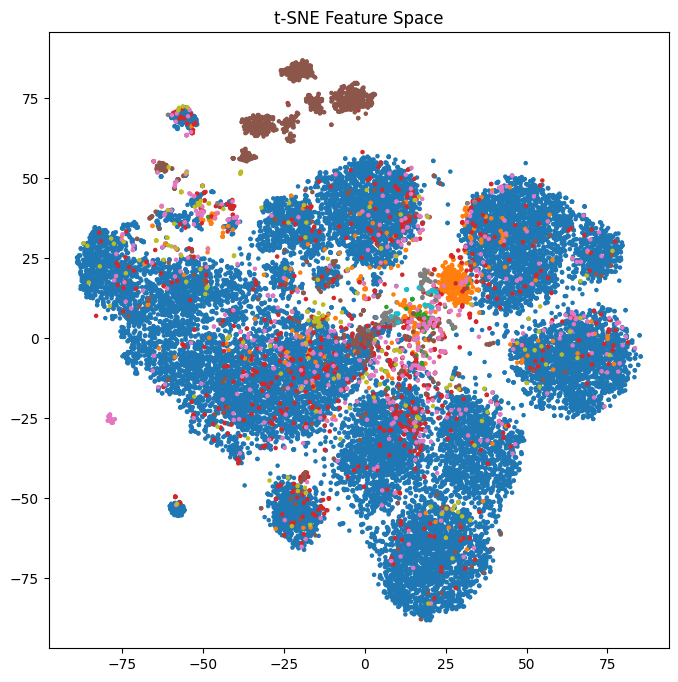

In [81]:
features = []
labels = []

model.eval()

with torch.no_grad():
    for x, y in val_loader:
        x = x.to(DEVICE)

        # Extract deep features (not predictions)
        feat = model.forward_features(x)

        # Global average pooling
        feat = feat.mean([-2, -1])

        features.append(feat.cpu().numpy())
        labels.extend(y.numpy())

# Stack into matrix
features = np.vstack(features)

print("Feature shape:", features.shape)

# Run t-SNE
emb = TSNE(n_components=2, perplexity=30).fit_transform(features)

plt.figure(figsize=(8,8))
plt.scatter(emb[:,0], emb[:,1], c=labels, cmap="tab10", s=5)
plt.title("t-SNE Feature Space")
plt.show()


In [84]:

!pip install onnx onnxruntime onnxscript


   ---------------------------------------- 0.0/689.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/689.1 kB ? eta -:--:--
   --------------- ------------------------ 262.1/689.1 kB ? eta -:--:--
   ------------------------------ --------- 524.3/689.1 kB 1.1 MB/s eta 0:00:01
   ------------------------------ --------- 524.3/689.1 kB 1.1 MB/s eta 0:00:01
   ------------------------------ --------- 524.3/689.1 kB 1.1 MB/s eta 0:00:01
   ---------------------------------------- 689.1/689.1 kB 433.9 kB/s  0:00:01

   ---------------------------------------- 0/2 [onnx_ir]
   ---------------------------------------- 0/2 [onnx_ir]
   ---------------------------------------- 0/2 [onnx_ir]
   ---------------------------------------- 0/2 [onnx_ir]
   ---------------------------------------- 0/2 [onnx_ir]
   ---------------------------------------- 0/2 [onnx_ir]
   ---------------------------------------- 0/2 [onnx_ir]
   ---------------------------------------- 0/2 [onnx_ir]
 

In [85]:
import torch
import timm
import onnx
import onnxruntime as ort

# ==============================
# CONFIG
# ==============================

MODEL_PATH = "best_model.pth"   # your trained model
ONNX_PATH = "wafer_model.onnx"

NUM_CLASSES = 9
IMG_SIZE = 256
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ==============================
# LOAD MODEL
# ==============================

model = timm.create_model(
    "convnext_tiny",
    pretrained=False,
    num_classes=NUM_CLASSES
)

model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()
model.to(DEVICE)

print("✅ Model loaded")

# ==============================
# DUMMY INPUT
# ==============================

dummy_input = torch.randn(
    1, 3, IMG_SIZE, IMG_SIZE
).to(DEVICE)

# ==============================
# EXPORT TO ONNX
# ==============================
torch.onnx.export(
    model,
    dummy_input,
    ONNX_PATH,
    export_params=True,
    opset_version=17,
    do_constant_folding=True,
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={
        "input": {0: "batch_size"},
        "output": {0: "batch_size"}
    },
    dynamo=False  # 👈 ADD THIS
)


print(f"✅ ONNX model saved to: {ONNX_PATH}")

# ==============================
# VERIFY ONNX MODEL
# ==============================

onnx_model = onnx.load(ONNX_PATH)
onnx.checker.check_model(onnx_model)


✅ Model loaded


C:\Users\Acer\AppData\Local\Temp\ipykernel_3720\1890268670.py:44: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter has become the default. Learn more about the new export logic: https://docs.pytorch.org/docs/stable/onnx_export.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html
  torch.onnx.export(


✅ ONNX model saved to: wafer_model.onnx
